In [1]:
import numpy as np
def gen_data(k,size=1000000):
  assert size >= k
  X = np.array(np.random.choice(2,size=(size,)))
  Y = [0]*size
  for i in range(size):
    sumk = 0
    for j in range(k):
      sumk = sumk + X[i-j]
    if (sumk)%2 == 1:
      Y[i] = 1
    else:
      Y[i] = 0
  return X, np.array(Y)

In [2]:
a, b = gen_data(4,10)
print(a)
print(b)

[0 1 1 1 1 0 1 1 0 0]
[1 1 0 1 0 1 1 1 0 0]


In [3]:
num_steps = 5
batch_size = 200

num_classes = 2
state_size = 8
learning_rate = 0.1
num_epochs = 1

In [4]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size, )))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)


def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype = np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype = np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length*i : batch_partition_length*(i+1)]
        data_y[i] = raw_y[batch_partition_length*i : batch_partition_length*(i+1)]

    epoch_size = batch_partition_length // num_steps
    for i in range(epoch_size):
        x = data_x[:, i*num_steps : (i+1)*num_steps]
        y = data_y[:, i*num_steps : (i+1)*num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

In [5]:
a, b = gen_data()
print(a)
print(b)

[1 0 0 ... 0 1 1]
[0 1 1 ... 0 1 1]


In [6]:
#pip install tensorflow==2.8

In [7]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior() 
#batch_size=200
#num_steps=5
#state_size=4
#num_classes=2
x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='label_placeholder')
init_state = tf.zeros([batch_size, state_size])

x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

Instructions for updating:
non-resource variables are not supported in the long term


In [8]:

import tensorflow.compat.v1 as tf
#tf.compat.v1.disable_eager_execution()
with tf.compat.v1.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes+state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.compat.v1.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes+state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

state = init_state
rnn_outputs = []

for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))

logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

y_as_list = tf.unstack(y, num=num_steps, axis=1)

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) \
          for logit, label in zip(logits, y_as_list)]

#learning_rate=0.001
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



EPOCH 0
Average loss at step 100 for last 100 steps: 0.534164417386055
Average loss at step 200 for last 200 steps: 0.49530324548482896
Average loss at step 300 for last 300 steps: 0.48906904339790347
Average loss at step 400 for last 400 steps: 0.48796346932649615
Average loss at step 500 for last 500 steps: 0.4806059336662292
Average loss at step 600 for last 600 steps: 0.48213317155838015
Average loss at step 700 for last 700 steps: 0.4801998382806778
Average loss at step 800 for last 800 steps: 0.4828509509563446
Average loss at step 900 for last 900 steps: 0.4822554674744606
Average loss at step 1000 for last 1000 steps: 0.48213470339775083


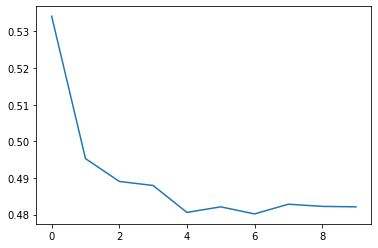

In [9]:
import matplotlib.pyplot as plt

def train_network(num_epochs, num_steps, state_size=state_size, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)): 
                                                                
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose :
                print("\nEPOCH", idx)

            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses, total_loss,
                              final_state, train_step],
                             feed_dict={x: X, y: Y, init_state: training_state})
                training_loss += training_loss_
                step += 1
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step, "for last", step  , "steps:", training_loss/100)
                        training_losses.append(training_loss/100)
                        training_loss = 0
    return training_losses

#num_epochs=100
training_losses = train_network(num_epochs, num_steps)
plt.plot(training_losses)
plt.show()